In [1]:
!pip install shap

     |████████████████████████████████| 564 kB 4.1 MB/s 


In [3]:
try:
  import google.colab
  !pip install --upgrade witwidget
except:
  pass

     |████████████████████████████████| 1.5 MB 3.7 MB/s 


In [9]:
import numpy as np
import tensorflow as tf
from pprint import pprint
import lightgbm as lgb
import shap, warnings, functools
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [7]:
from google.colab import files
uploaded = files.upload()

Saving hotel_bookings.csv to hotel_bookings.csv


In [10]:
data=pd.read_csv("hotel_bookings.csv")

In [11]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [14]:
data.is_canceled.value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [16]:
data.arrival_date_month.value_counts()

August       13877
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: arrival_date_month, dtype: int64

In [18]:
features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
"stays_in_weekend_nights","stays_in_week_nights","adults","children",
"babies","is_repeated_guest", "previous_cancellations",
"previous_bookings_not_canceled","agent","company",
"required_car_parking_spaces", "total_of_special_requests",
"adr","hotel","arrival_date_month","meal","market_segment",
"distribution_channel","reserved_room_type","deposit_type","customer_type",'is_canceled']

In [19]:
raw_data = data[features]

In [21]:
X = raw_data.drop(["is_canceled"], axis=1)
y = raw_data["is_canceled"]
X_display =X.copy()
y_display = y.copy()
X_new=X.copy()

In [23]:
X.dtypes

lead_time                           int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
agent                             float64
company                           float64
required_car_parking_spaces         int64
total_of_special_requests           int64
adr                               float64
hotel                              object
arrival_date_month                 object
meal                               object
market_segment                     object
distribution_channel               object
reserved_room_type                 object
deposit_type                       object
customer_type                     

In [24]:
def transform_categorical():
  s = (X.dtypes == 'object')
  object_cols = list(s[s].index)
  print(object_cols)
  for i in object_cols:
    lb_make = LabelEncoder()
    X[i] = lb_make.fit_transform(X[i])
#for i in object_cols:
# X[i] = X[i].astype(float)
  return X

In [25]:
X=transform_categorical()
X.head()

['hotel', 'arrival_date_month', 'meal', 'market_segment', 'distribution_channel', 'reserved_room_type', 'deposit_type', 'customer_type']


,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,required_car_parking_spaces,total_of_special_requests,adr,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type
0,342,27,1,0,0,2,0.0,0,0,0,0,NaN,NaN,0,0,0.0,1,5,0,3,1,2,0,2
1,737,27,1,0,0,2,0.0,0,0,0,0,NaN,NaN,0,0,0.0,1,5,0,3,1,2,0,2
2,7,27,1,0,1,1,0.0,0,0,0,0,NaN,NaN,0,0,75.0,1,5,0,3,1,0,0,2
3,13,27,1,0,1,1,0.0,0,0,0,0,304.0,NaN,0,0,75.0,1,5,0,2,0,0,0,2
4,14,27,1,0,2,2,0.0,0,0,0,0,240.0,NaN,0,1,98.0,1,5,0,6,3,0,0,2


In [26]:
def data_split():
  random_state = 7
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=random_state)
  return X_train, X_test, y_train, y_test

In [27]:
X_train, X_test, y_train, y_test=data_split()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,required_car_parking_spaces,total_of_special_requests,adr,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type
100903,36,45,1,0,3,2,0.0,0,0,0,0,28.0,NaN,0,0,75.00,0,9,0,5,3,0,0,2
3198,78,47,21,0,1,2,0.0,0,0,0,0,NaN,342.0,0,0,32.00,1,9,0,2,0,0,0,3
102316,6,48,25,0,1,2,0.0,0,0,0,0,9.0,NaN,0,1,95.00,0,9,3,6,3,0,0,2
92195,2,27,1,0,1,2,0.0,0,0,0,0,14.0,NaN,0,0,147.00,0,5,0,3,1,0,0,2
91892,53,26,24,1,2,2,0.0,0,0,0,0,1.0,NaN,0,1,65.00,0,6,0,4,3,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104003,5,1,1,2,0,2,0.0,0,0,0,0,14.0,NaN,0,1,110.25,0,4,0,3,1,3,0,2
10742,57,13,31,0,2,2,0.0,0,0,0,0,240.0,NaN,0,0,60.00,1,7,0,6,3,0,0,2
49689,14,17,17,2,1,2,0.0,0,0,0,0,9.0,NaN,0,0,89.00,0,0,3,6,3,0,0,2
58564,37,42,13,0,3,2,0.0,0,0,0,0,56.0,NaN,0,0,105.00,0,10,0,5,3,0,0,3


In [29]:
#preparing the data for lgm model
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [30]:
random_state=7
params = {
"max_bin": 512, "learning_rate": 0.05,"boosting_type": "gbdt",
"objective": "binary","metric": "binary_logloss", "num_leaves": 10,
"verbose": -1, "min_data": 100, "boost_from_average": True,
"random_state": random_state
}

In [31]:
model = lgb.train(params, d_train, 10000, valid_sets=[d_test],early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds.
[1000]	valid_0's binary_logloss: 0.345268
[2000]	valid_0's binary_logloss: 0.334481
[3000]	valid_0's binary_logloss: 0.328818
[4000]	valid_0's binary_logloss: 0.325363
[5000]	valid_0's binary_logloss: 0.322425
Early stopping, best iteration is:
[5488]	valid_0's binary_logloss: 0.321515


In [35]:
#visualise our results with the advanced AI technique with the help of Shap to have a better visibility

explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
  expected_value = expected_value[1]
  print(expected_value)
  printf( "Explainer expected value: {expected_value}")

In [36]:
select = range(20)
features = X_test.iloc[select]
features_display = X_display.loc[features.index]

In [37]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  shap_values = explainer.shap_values(features)[1]
  shap_interaction_values = explainer.shap_interaction_values(features)
  if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

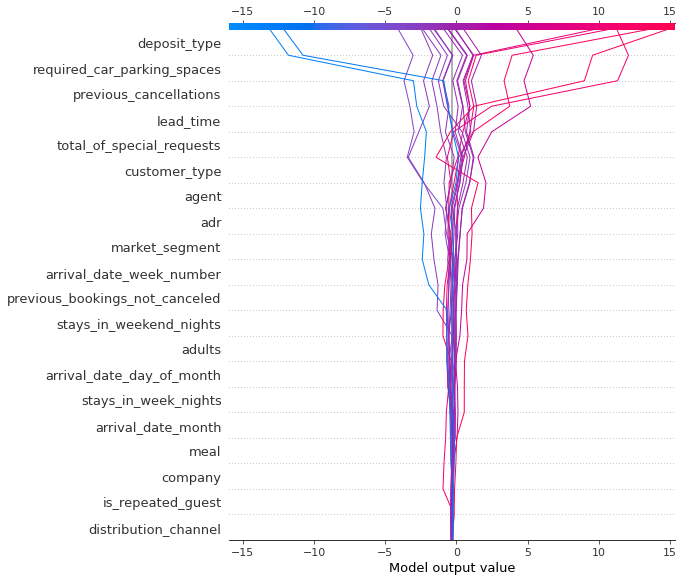

In [39]:
shap.decision_plot(expected_value, shap_values, features_display)

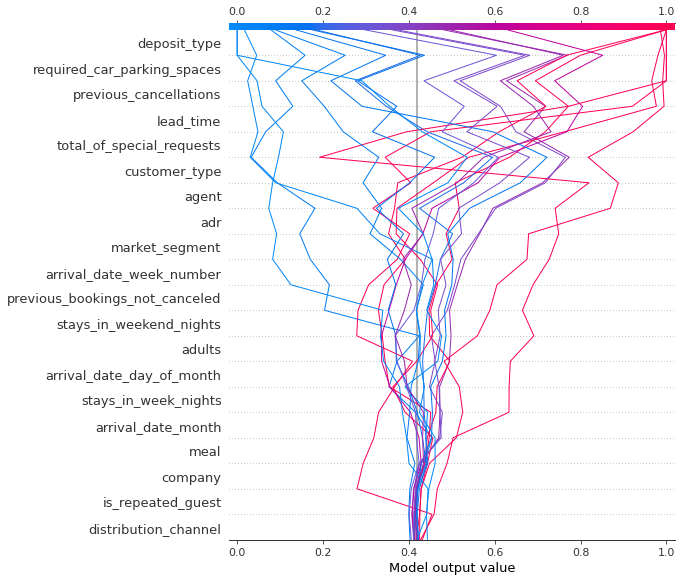

In [40]:
shap.decision_plot(expected_value, shap_values, features_display,
link='logit')

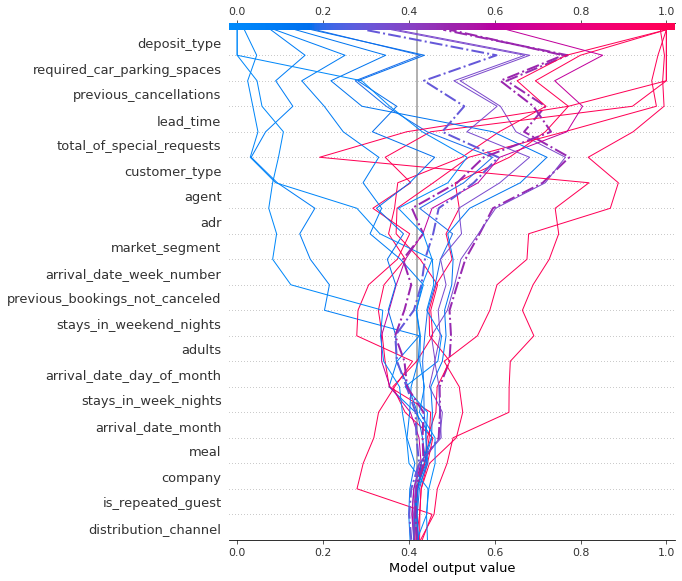

In [42]:
y_pred = (shap_values.sum(1) + expected_value) > 0
misclassified = y_pred != y_test[:20]
shap.decision_plot(expected_value, shap_values, features_display,
link='logit', highlight=misclassified)

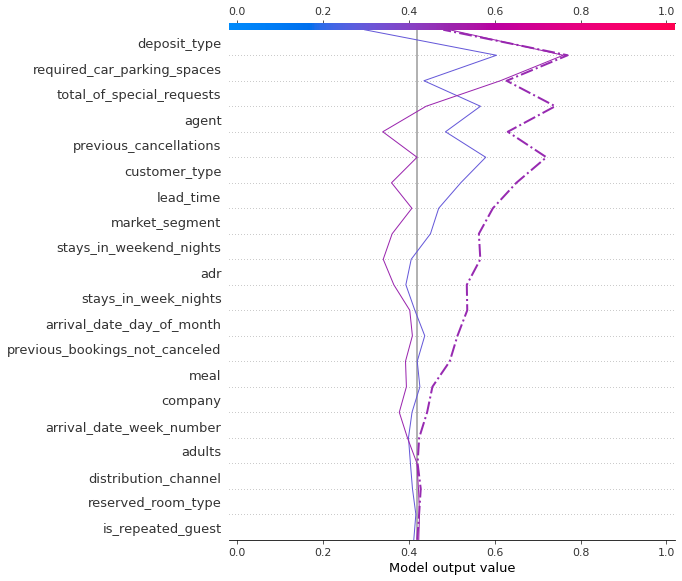

In [43]:
shap.decision_plot(expected_value, shap_values[misclassified],
features_display[misclassified],link='logit', highlight=0)

In [44]:
%matplotlib inline
shap.initjs()
shap.force_plot(expected_value, shap_values[misclassified],
features_display[misclassified],
link='logit', matplotlib=False,show=True)

In [45]:
#analyse the Model analysis with the Tensorboard and what-if tool

X = raw_data.drop(["is_canceled"], axis=1)
y = raw_data["is_canceled"]
from sklearn.model_selection import train_test_split
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2,
random_state = 0)
xTrain['is_canceled']=yTrain
xTrain.reset_index(inplace=True,drop=True)
xTrain.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,required_car_parking_spaces,total_of_special_requests,adr,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,is_canceled
0,66,32,6,2,2,3,0.0,0,0,0,0,9.0,NaN,0,0,168.3,City Hotel,August,BB,Online TA,TA/TO,D,No Deposit,Transient,1
1,51,36,31,1,4,2,0.0,0,0,0,0,9.0,NaN,0,0,123.3,City Hotel,August,BB,Online TA,TA/TO,D,No Deposit,Transient,1
2,22,38,15,0,1,1,0.0,0,0,0,0,9.0,NaN,0,2,149.0,City Hotel,September,BB,Online TA,TA/TO,A,No Deposit,Transient,0
3,69,11,17,2,3,2,2.0,0,0,0,0,9.0,NaN,0,0,153.0,City Hotel,March,BB,Online TA,TA/TO,F,No Deposit,Transient,1
4,14,17,25,0,4,2,2.0,0,0,0,0,14.0,NaN,1,2,324.5,City Hotel,April,HB,Direct,Direct,G,No Deposit,Transient,0


In [46]:
def create_feature_spec(df, columns=None):
  feature_spec = {}
  if columns == None:
    columns = df.columns.values.tolist()
  for f in columns:
    if df[f ].dtype is np.dtype(np.int64):
      feature_spec[f ] = tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
    elif df[f ].dtype is np.dtype(np.float64):
      feature_spec[f ] = tf.io.FixedLenFeature(shape=(), dtype=tf.float32)
    else:
      feature_spec[f ] = tf.io.FixedLenFeature(shape=(), dtype=tf.string)
  return feature_spec

In [47]:
def create_feature_columns(columns, feature_spec):
  ret = []
  for col in columns:
    if feature_spec[col].dtype is tf.int64 or feature_spec[col].dtype is tf.float32:
      ret.append(tf.feature_column.numeric_column(col))
    else:
      ret.append(tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(col,list(xTrain[col].unique()))))
  return ret

In [49]:
def tfexamples_input_fn(examples, feature_spec, label,mode=tf.estimator.ModeKeys.EVAL,num_epochs=None, batch_size=64):
  def ex_generator():
    for i in range(len(examples)):
      yield examples[i].SerializeToString()
  dataset = tf.data.Dataset.from_generator(ex_generator, tf.dtypes.string, tf.TensorShape([]))
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(buffer_size=2 * batch_size + 1)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda tf_example: parse_tf_example(tf_example, label, feature_spec))
    dataset = dataset.repeat(num_epochs)
  return dataset

In [50]:
def parse_tf_example(example_proto, label, feature_spec):
  parsed_features = tf.io.parse_example(serialized=example_proto,features=feature_spec)
  target = parsed_features.pop(label)
  return parsed_features, target

In [52]:
def df_to_examples(df, columns=None):
  examples = []
  if columns == None:
    columns = df.columns.values.tolist()
  for index, row in df.iterrows():
    example = tf.train.Example()
    for col in columns:
      if df[col].dtype is np.dtype(np.int64):
        example.features.feature[col].int64_list.value.append(int(row[col]))
      elif df[col].dtype is np.dtype(np.float64):
        example.features.feature[col].float_list.value.append(row[col])
      elif row[col] == row[col]:
        example.features.feature[col].bytes_list.value.append(row[col].encode('utf-8'))
    examples.append(example)
  return examples

In [53]:
def make_label_column_numeric(df, label_column, test):
  df[label_column] = np.where(test(df[label_column]), 1, 0)

In [56]:
label_column = 'is_canceled'
input_features = ['lead_time', 'arrival_date_week_number','arrival_date_day_of_month','stays_in_weekend_nights', 'stays_in_week_nights', 'adults','children','babies', 'is_repeated_guest','previous_cancellations','previous_bookings_not_canceled', 'agent','company', 'required_car_parking_spaces', 'total_of_special_requests','adr','hotel', 'arrival_date_month', 'meal','market_segment','distribution_channel', 'reserved_room_type','deposit_type', 'customer_type']

In [57]:
features_and_labels = input_features + [label_column]

In [58]:
features_and_labels

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'agent',
 'company',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'adr',
 'hotel',
 'arrival_date_month',
 'meal',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'deposit_type',
 'customer_type',
 'is_canceled']

In [59]:
xTrain.head()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,agent,company,required_car_parking_spaces,total_of_special_requests,adr,hotel,arrival_date_month,meal,market_segment,distribution_channel,reserved_room_type,deposit_type,customer_type,is_canceled
0,66,32,6,2,2,3,0.0,0,0,0,0,9.0,NaN,0,0,168.3,City Hotel,August,BB,Online TA,TA/TO,D,No Deposit,Transient,1
1,51,36,31,1,4,2,0.0,0,0,0,0,9.0,NaN,0,0,123.3,City Hotel,August,BB,Online TA,TA/TO,D,No Deposit,Transient,1
2,22,38,15,0,1,1,0.0,0,0,0,0,9.0,NaN,0,2,149.0,City Hotel,September,BB,Online TA,TA/TO,A,No Deposit,Transient,0
3,69,11,17,2,3,2,2.0,0,0,0,0,9.0,NaN,0,0,153.0,City Hotel,March,BB,Online TA,TA/TO,F,No Deposit,Transient,1
4,14,17,25,0,4,2,2.0,0,0,0,0,14.0,NaN,1,2,324.5,City Hotel,April,HB,Direct,Direct,G,No Deposit,Transient,0


In [60]:
examples = df_to_examples(xTrain)

In [61]:
num_steps = 2000
feature_spec = create_feature_spec(xTrain, features_and_labels)

feature_spec

{'adr': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'adults': FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'agent': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'arrival_date_day_of_month': FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'arrival_date_month': FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'arrival_date_week_number': FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'babies': FixedLenFeature(shape=(), dtype=tf.int64, default_value=None),
 'children': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'company': FixedLenFeature(shape=(), dtype=tf.float32, default_value=None),
 'customer_type': FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'deposit_type': FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'distribution_channel': FixedLenFeature(shape=(), dtype=tf.string, default_value=None),
 'hotel': FixedLenFeature

In [62]:
train_inpf = functools.partial(tfexamples_input_fn, examples,
feature_spec, label_column)